# NiftyRegPy Tutorial

This is a simple tutorial on how to use the niftyregpy package

## Installation

In [ ]:
%%bash

[ -d /content/niftyreg ] && rm -r /content/niftyreg
git clone https://github.com/KCL-BMEIS/niftyreg/ /content/niftyreg

mkdir -p /content/niftyreg/build
cd /content/niftyreg/build
cmake .. &> /dev/null
make &> /dev/null
make install &> /dev/null


Cloning into '/content/niftyreg'...


In [ ]:
# Install niftyregpy and scikit-image (for transforms)
%pip install --quiet git+https://github.com/fyrdahl/niftyregpy 
%pip install --quiet scikit-image tqdm

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


## Examples

In [ ]:
import niftyregpy as nr
import numpy as np
import matplotlib.pyplot as plt

from skimage import transform
from skimage.metrics import mean_squared_error as mse
from tqdm import tqdm

def colorband(A,B):
  out = np.dstack((A,B,A))
  return (out/out.max() * 255).astype(np.uint8)

### Simple rigid registration
We create a test image with the built-in "create_test_image" function. Then we shift the test image slightly to create the "floating" image.

We then perform a single rigid registration step to try to register the shifted image to the original.

[[ 1.    0.    0.   14.65]
 [-0.    1.    0.    0.01]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]



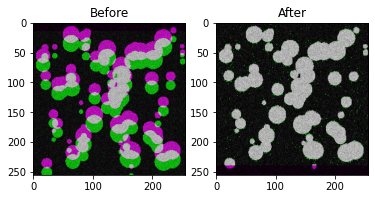

In [ ]:
# Create a random test image containing blobs
img = nr.utils.create_test_image(blobs=64, max_rad=16)

# Add noise for robustness
img = np.abs(img + np.random.normal(0, 0.1, img.shape))

# Shift the image
img_shifted = np.zeros_like(img)
img_shifted[15:, :] = img[:-15, :]

# Perform one rigid registration
ref, flo = img, img_shifted
res = nr.reg.aladin(ref, flo, rigOnly=True)

# Print final affine transform matrix
print(f"{np.array_str(res[1], precision=2, suppress_small=True)}\n")

# Plot results
plt.figure()

plt.subplot(1,2,1)
plt.imshow(colorband(img, img_shifted))
plt.title('Before')

plt.subplot(1,2,2)
plt.imshow(colorband(img, res[0]))
plt.title('After')

plt.show()


### Serial rigid and affine registrations

Same as the previous example, except that we both shift and shear the image.

We then perform 5 registration steps, where the first step is constrained to be rigid and the subsequent steps are affine.

Affine registration: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


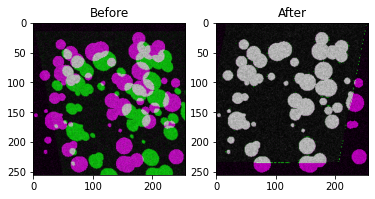

In [ ]:
# Create a random test image containing blobs
img = nr.utils.create_test_image(blobs=64, max_rad=16)

# Add noise for robustness
img = np.abs(img + np.random.normal(0, 0.1, img.shape))

# Shift the image
img_shifted = np.zeros_like(img)
img_shifted[15:, :] = img[:-15, :]

# Shear the image using skimage
tform_shear = transform.AffineTransform(shear=np.pi/16)
img_sheared = transform.warp(img_shifted, tform_shear)

# Perform serial rigid and affine registrations
ref, flo = img, img_sheared
for iter in tqdm(range(5), desc="Affine registration"):
  res = nr.reg.aladin(ref, flo, rigOnly=(iter==0))
  flo = res[0]

# Plot results
plt.figure()

plt.subplot(1,2,1)
plt.imshow(colorband(img, img_sheared))
plt.title('Before')

plt.subplot(1,2,2)
plt.imshow(colorband(img, res[0]))
plt.title('After')

plt.show()



### Serial affine and non-rigid registration

Same as the previous example, except that we shift, shear and swirl the image.

We then perform 5 affine registrations steps, followed by 10 non-rigid registrations steps.

Affine Registration: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it, MSE=0.0466]


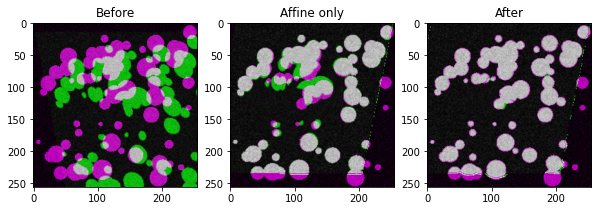

In [ ]:
# Create a random test image containing blobs
img = nr.utils.create_test_image(blobs=64, max_rad=16)

# Add noise for robustness
img = np.abs(img + np.random.normal(0, 0.1, img.shape))

# Shift the image
img_shifted = np.zeros_like(img)
img_shifted[15:, :] = img[:-15, :]

# Shear the image using skimage
tform_shear = transform.AffineTransform(shear=np.pi/16)
img_sheared = transform.warp(img_shifted, tform_shear)

# Swirl the image using skimage
c = map(lambda x: x//2, img_sheared.shape)
img_swirled = transform.swirl(img_sheared, center=c, strength=2, radius=128)

# Perform serial rigid and affine registrations
ref, flo = img, img_swirled
aff_iter = 5
with tqdm(total=aff_iter, desc="Affine Registration") as pbar:
  for iter in range(aff_iter):
    res = nr.reg.aladin(ref, flo, rigOnly=(iter==0))
    flo = res[0]
    pbar.set_postfix(MSE=mse(ref,flo))
    pbar.update()

intermed = flo

# Perform serial non-rigid registrations
nrr_iter = 5
with tqdm(total=nrr_iter, desc="Affine Registration") as pbar:
  for iter in range(nrr_iter):
    res = nr.reg.f3d(ref, flo)
    flo = res[0]
    pbar.set_postfix(MSE=mse(ref,flo))
    pbar.update()

# Plot results
plt.figure(figsize=(10,30))

plt.subplot(1,3,1)
plt.imshow(colorband(img, img_swirled))
plt.title('Before')

plt.subplot(1,3,2)
plt.imshow(colorband(img, intermed))
plt.title('Affine only')

plt.subplot(1,3,3)
plt.imshow(colorband(img, res[0]))
plt.title('After')

plt.show()